In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import requests
from bs4 import BeautifulSoup as BS
import re
import warnings
import folium
import bokeh
from numpy import NaN
import matplotlib.pyplot as plt
import scrapy
from pybaseball import pitching_stats
from pybaseball import statcast_single_game,statcast_pitcher,pitching_stats_bref
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import schedule_and_record
import seaborn as sns


from sklearn import metrics
from sklearn.cluster import k_means,KMeans,hierarchical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [2]:
cluster_data = pd.read_csv('cluster_data.csv')

cluster_data = cluster_data.drop(columns=['Age','WAR','Pace (pi)', 'Contact% (pi)','Zone% (pi)'])

awards_players = pd.read_csv('AwardsPlayers.csv')

People = pd.read_csv('People.csv')

In [3]:
awards_players = pd.merge(awards_players,People,on='playerID')

In [4]:
awards_players_2006 = awards_players.loc[awards_players['yearID'] >= 2006]

In [5]:
cy_young = awards_players_2006.loc[awards_players_2006['awardID'] == 'Cy Young Award']

cy_young = cy_young[['playerID','awardID','yearID','lgID','nameFirst','nameLast']]

cy_young['Name'] = cy_young['nameFirst'] + ' ' + cy_young['nameLast']

cy_young = cy_young.drop(columns=['nameFirst','nameLast'])

cy_young['Winner'] = True

cy_young = cy_young.rename(columns={'yearID':'Season'})

cy_young = cy_young.drop(columns=['lgID','playerID','awardID'])

cy_young.head()

,Season,Name,Winner
5456,2010,Roy Halladay,True
5513,2006,Johan Santana,True
5626,2006,Brandon Webb,True
5638,2011,Justin Verlander,True
5708,2007,CC Sabathia,True


In [6]:
cluster_data = pd.merge(cluster_data,cy_young,how='left')

In [7]:
cluster_data = cluster_data.fillna(False)

In [8]:
cluster_data['Winner'] = cluster_data['Winner'].astype(int)

In [9]:
cluster_data = cluster_data[['Season','Name','Winner','IP','K/9','BB/9','tERA','HR/9','LOB%','FIP','GB/FB','BABIP','K%','BB%','SwStr%']]

## Cluster Time

In [10]:
cluster_data.loc[(cluster_data['Name']=='Jacob deGrom') & (cluster_data['Season'] == 2018.0),'Winner'] = 1

cluster_data.loc[(cluster_data['Name']=='Blake Snell') & (cluster_data['Season'] == 2018.0),'Winner'] = 1

cluster_data.head()

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%
0,2018.0,Jacob deGrom,1,217.0,11.16,1.91,2.15,0.41,0.820,1.99,1.47,0.281,0.322,0.055,0.151
1,2011.0,Roy Halladay,0,233.2,8.47,1.35,2.46,0.39,0.781,2.20,1.67,0.298,0.236,0.038,0.109
2,2015.0,Clayton Kershaw,0,232.2,11.64,1.62,2.28,0.58,0.783,1.99,1.77,0.281,0.338,0.047,0.159
3,2009.0,Zack Greinke,1,229.1,9.50,2.00,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.100
4,2009.0,Justin Verlander,0,240.0,10.09,2.36,3.18,0.75,0.727,2.80,0.84,0.319,0.274,0.064,0.114


In [11]:
X = cluster_data.iloc[:, 3:15].values  
y = cluster_data.iloc[:, :3].values 

In [12]:
X

array([[2.170e+02, 1.116e+01, 1.910e+00, ..., 3.220e-01, 5.500e-02,
        1.510e-01],
       [2.332e+02, 8.470e+00, 1.350e+00, ..., 2.360e-01, 3.800e-02,
        1.090e-01],
       [2.322e+02, 1.164e+01, 1.620e+00, ..., 3.380e-01, 4.700e-02,
        1.590e-01],
       ...,
       [1.091e+02, 4.030e+00, 3.620e+00, ..., 9.600e-02, 8.600e-02,
        5.700e-02],
       [1.990e+02, 4.880e+00, 2.040e+00, ..., 1.260e-01, 5.300e-02,
        5.900e-02],
       [4.010e+01, 6.470e+00, 6.920e+00, ..., 1.440e-01, 1.540e-01,
        6.900e-02]])

In [13]:
y

array([[2018.0, 'Jacob deGrom', 1],
       [2011.0, 'Roy Halladay', 0],
       [2015.0, 'Clayton Kershaw', 0],
       ...,
       [2010.0, 'Ryan Rowland-Smith', 0],
       [2011.0, 'Bronson Arroyo', 0],
       [2011.0, 'Scott Proctor', 0]], dtype=object)

In [14]:
scaler = StandardScaler()
 
X_scaled = scaler.fit_transform(X) 

In [15]:
kmeans = KMeans(n_clusters=3, max_iter=1000, algorithm = 'auto')

#kmeans_messy = KMeans(n_clusters=3, max_iter=1000, algorithm = 'auto')
kmeans.fit_transform(X_scaled)

array([[3.34198968, 5.16434051, 9.10925125],
       [3.31955889, 4.00261168, 8.40296123],
       [3.77881963, 5.57516162, 9.41512429],
       ...,
       [4.26965191, 2.06520493, 4.36165653],
       [4.27108475, 2.80944775, 5.91113516],
       [4.16728222, 2.92849178, 2.59071794]])

In [16]:
#gm_messy = GaussianMixture(n_components=3).fit(X).predict(X)

#plt.scatter(X[:,11], X[:,4], c=gm_messy, cmap='plasma')

#fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
#print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
#fig_size[0] = 12
#fig_size[1] = 9
#plt.scatter(kmeans.cluster_centers_[:,10] ,kmeans.cluster_centers_[:,3], color='black') 

In [17]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

In [18]:
X_r

array([[-3.95691831,  0.42777593],
       [-2.79953279, -1.31667761],
       [-4.17674119,  0.49385503],
       ...,
       [ 1.92378861, -1.51017552],
       [ 0.68202041, -2.19567885],
       [ 2.56005999,  0.96283566]])

In [19]:
kmeans.cluster_centers_

array([[ 0.07354562,  0.84726493, -0.15762835, -0.46780399, -0.22605686,
         0.33136068, -0.4647049 , -0.09679085, -0.1487831 ,  0.92054031,
        -0.08120174,  0.8128684 ],
       [ 0.06923101, -0.50985314, -0.1325949 ,  0.0303646 , -0.08528011,
        -0.13965827,  0.00992798,  0.10330812,  0.06168674, -0.51675472,
        -0.13996175, -0.47278375],
       [-0.9519906 , -0.76639759,  1.91720875,  2.38263791,  1.93122353,
        -0.76586101,  2.52473603, -0.2640404 ,  0.35184059, -1.12286801,
         1.54672269, -0.8630135 ]])

In [20]:
print(kmeans.labels_)

[0 0 0 ... 1 1 2]


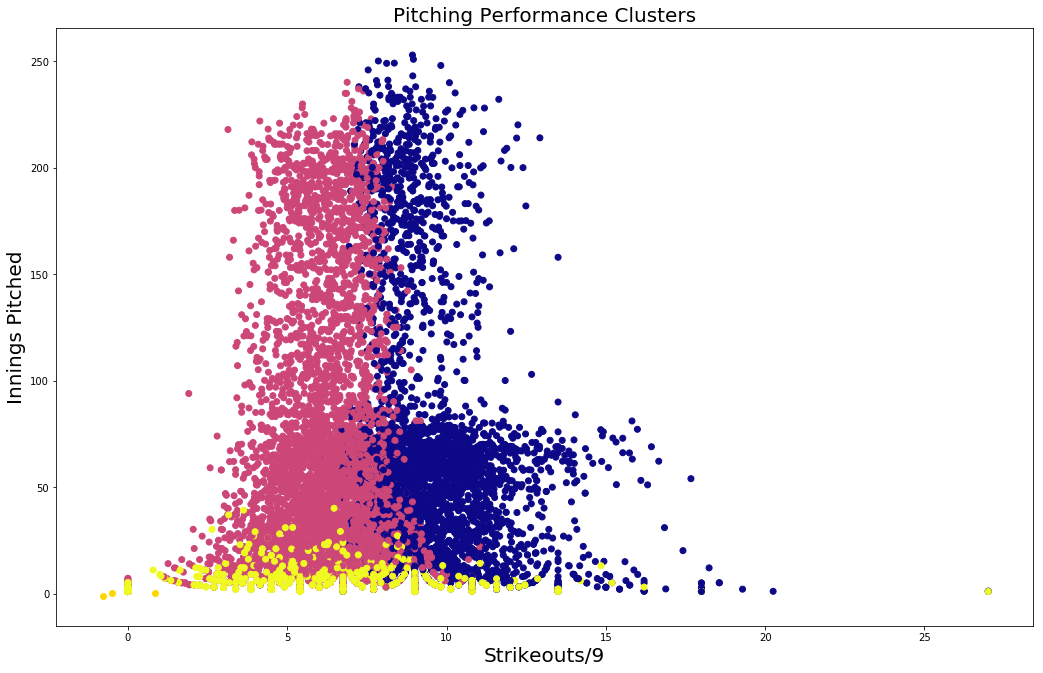

In [59]:
plt.scatter(X[:,1], X[:,0], c=kmeans.labels_, cmap='plasma')
plt.xlabel('Strikeouts/9',fontsize=20)
plt.ylabel('Innings Pitched',fontsize=20)
plt.title('Pitching Performance Clusters',fontsize=20)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17.5
fig_size[1] = 11
plt.scatter(kmeans.cluster_centers_[:,1] ,kmeans.cluster_centers_[:,0], color='gold') 

In [22]:
cluster_data['Cluster'] = kmeans.predict(X_scaled)

In [23]:
cluster_data.head()

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster
0,2018.0,Jacob deGrom,1,217.0,11.16,1.91,2.15,0.41,0.820,1.99,1.47,0.281,0.322,0.055,0.151,0
1,2011.0,Roy Halladay,0,233.2,8.47,1.35,2.46,0.39,0.781,2.20,1.67,0.298,0.236,0.038,0.109,0
2,2015.0,Clayton Kershaw,0,232.2,11.64,1.62,2.28,0.58,0.783,1.99,1.77,0.281,0.338,0.047,0.159,0
3,2009.0,Zack Greinke,1,229.1,9.50,2.00,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.100,0
4,2009.0,Justin Verlander,0,240.0,10.09,2.36,3.18,0.75,0.727,2.80,0.84,0.319,0.274,0.064,0.114,0


In [24]:
cm = sns.light_palette("xkcd:light gold", as_cmap=True)

aroldis_chapman = cluster_data.loc[cluster_data['Name']=='Aroldis Chapman']

aroldis_chapman.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster
502,2012,Aroldis Chapman,0,71.2,15.32,2.89,1.65,0.5,0.869,1.55,0.87,0.252,0.442,0.083,0.179,0
622,2014,Aroldis Chapman,0,54,17.67,4,1.04,0.17,0.768,0.89,1.25,0.29,0.525,0.119,0.202,0
667,2016,Aroldis Chapman,0,58,13.97,2.79,1.91,0.31,0.805,1.42,1.58,0.268,0.405,0.081,0.186,0
766,2015,Aroldis Chapman,0,66.1,15.74,4.48,2.13,0.41,0.885,1.94,0.9,0.331,0.417,0.119,0.193,0
1145,2018,Aroldis Chapman,0,51.1,16.31,5.26,2.07,0.35,0.783,2.09,1.19,0.268,0.439,0.142,0.161,0
1223,2013,Aroldis Chapman,0,63.2,15.83,4.1,2.92,0.99,0.862,2.47,0.79,0.28,0.434,0.112,0.165,0
1473,2017,Aroldis Chapman,0,50.1,12.34,3.58,2.46,0.54,0.717,2.56,1.39,0.296,0.329,0.095,0.136,0
2939,2010,Aroldis Chapman,0,13.1,12.83,3.38,1.18,0,0.714,1.35,4.75,0.333,0.373,0.098,0.149,0
3147,2011,Aroldis Chapman,0,50,12.78,7.38,3.41,0.36,0.717,3.29,1.71,0.242,0.343,0.198,0.139,0


In [25]:
len(cluster_data.loc[cluster_data['Cluster']==248])

0

In [26]:
cluster_248 = cluster_data.loc[cluster_data.Cluster == 248]

cluster_248.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster


In [27]:
winner_data = cluster_data.loc[cluster_data['Winner']==1]

winner_data.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster
0,2018,Jacob deGrom,1,217,11.16,1.91,2.15,0.41,0.82,1.99,1.47,0.281,0.322,0.055,0.151,0
3,2009,Zack Greinke,1,229.1,9.5,2,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.1,0
5,2014,Clayton Kershaw,1,198.1,10.85,1.41,1.84,0.41,0.816,1.81,1.77,0.278,0.319,0.041,0.142,0
7,2009,Tim Lincecum,1,225.1,10.42,2.72,2.55,0.4,0.759,2.34,1.43,0.282,0.288,0.075,0.109,0
8,2011,Clayton Kershaw,1,233.1,9.57,2.08,2.48,0.58,0.786,2.47,1.12,0.269,0.272,0.059,0.112,0
12,2017,Corey Kluber,1,203.2,11.71,1.59,2.93,0.93,0.826,2.5,1.33,0.267,0.341,0.046,0.156,0
13,2013,Clayton Kershaw,1,236,8.85,1.98,2.87,0.42,0.806,2.39,1.47,0.251,0.256,0.057,0.114,0
14,2008,Tim Lincecum,1,227,10.51,3.33,2.95,0.44,0.779,2.62,1.25,0.304,0.286,0.091,0.119,0
15,2014,Corey Kluber,1,235.2,10.27,1.95,2.79,0.53,0.786,2.35,1.57,0.316,0.283,0.054,0.12,0
17,2015,Jake Arrieta,1,229,9.28,1.89,2.77,0.39,0.8,2.35,2.47,0.246,0.271,0.055,0.111,0


In [28]:
Counter(winner_data.Cluster).most_common()

[(0, 22), (1, 3)]

In [29]:
Cy_young_yes = ['Jacob deGrom','Zack Greinke','Clayton Kershaw','Tim Lincecum',
 'Corey Kluber',
 'Jake Arrieta',
 'Cliff Lee',
 'Felix Hernandez',
 'Jake Peavy',
 'Johan Santana',
 'Justin Verlander',
 'Brandon Webb',
 'CC Sabathia',
 'Roy Halladay',
 'Max Scherzer',
 'Dallas Keuchel',
 'Rick Porcello',
 'Blake Snell',
 'David Price']

In [30]:
cluster_data['Cy_young_winner'] = np.where(cluster_data["Name"].isin(Cy_young_yes), 1, 0)

Counter(cluster_data.Cy_young_winner)

Counter({1: 175, 0: 8711})

In [31]:
all_cy_young_seasons = cluster_data.loc[cluster_data.Cy_young_winner == 1]

Counter(all_cy_young_seasons.Cluster).most_common();

In [32]:
print(cluster_data.loc[cluster_data['Name']=="Clayton Kershaw"])

print(cluster_data.loc[cluster_data['Cluster']==130]);

      Season             Name  Winner     IP    K/9  BB/9  tERA  HR/9   LOB%  \
2     2015.0  Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58  0.783   
5     2014.0  Clayton Kershaw       1  198.1  10.85  1.41  1.84  0.41  0.816   
8     2011.0  Clayton Kershaw       1  233.1   9.57  2.08  2.48  0.58  0.786   
13    2013.0  Clayton Kershaw       1  236.0   8.85  1.98  2.87  0.42  0.806   
37    2016.0  Clayton Kershaw       0  149.0  10.39  0.66  1.91  0.48  0.800   
43    2012.0  Clayton Kershaw       0  227.2   9.05  2.49  2.97  0.63  0.779   
174   2010.0  Clayton Kershaw       0  204.1   9.34  3.57  2.98  0.57  0.762   
194   2017.0  Clayton Kershaw       0  175.0  10.39  1.54  3.05  1.18  0.874   
242   2009.0  Clayton Kershaw       0  171.0   9.74  4.79  3.07  0.37  0.775   
424   2018.0  Clayton Kershaw       0  161.1   8.65  1.62  3.59  0.95  0.787   
1679  2008.0  Clayton Kershaw       0  107.2   8.36  4.35  4.36  0.92  0.757   

       FIP  GB/FB  BABIP     K%    BB% 

In [33]:
Counter(cluster_data.Cy_young_winner).most_common()

[(0, 8711), (1, 175)]

In [34]:
cy_young_cluster = cluster_data.loc[cluster_data['Cluster']==351]

In [35]:
print('Number of cy young seasons in this cluster:',cy_young_cluster['Winner'].sum())

print('Number of cy young winners in this cluster', cy_young_cluster['Cy_young_winner'].sum())

print('Total # of pitchers:',len(cy_young_cluster))

Number of cy young seasons in this cluster: 0
Number of cy young winners in this cluster 0
Total # of pitchers: 0


In [36]:
cy_young_cluster.sort_values(by='Winner',ascending=False).head(10)

cy_young_cluster.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster,Cy_young_winner


In [37]:
print(cluster_data.groupby('Cluster')['Cy_young_winner'].sum().sort_values(ascending=False).head(10))

Cluster
0    118
1     56
2      1
Name: Cy_young_winner, dtype: int64


In [38]:
grouped = cluster_data.groupby('Cluster')
grouped.get_group(1)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster,Cy_young_winner
22,2008.0,Cliff Lee,1,223.1,6.85,1.37,2.96,0.48,0.783,2.83,1.31,0.301,0.191,0.038,0.081,1,1
32,2006.0,Brandon Webb,1,235.0,6.82,1.91,3.52,0.57,0.721,3.18,4.06,0.287,0.187,0.053,0.089,1,1
36,2009.0,Cliff Lee,0,231.2,7.03,1.67,3.65,0.66,0.762,3.11,1.13,0.315,0.187,0.044,0.081,1,1
42,2007.0,Brandon Webb,0,236.1,7.39,2.74,3.58,0.46,0.724,3.24,3.07,0.285,0.199,0.074,0.091,1,1
46,2006.0,Roy Oswalt,0,220.2,6.77,1.55,3.52,0.73,0.787,3.30,1.55,0.302,0.185,0.042,0.081,1,0
81,2008.0,Brandon Webb,0,226.2,7.27,2.58,3.40,0.52,0.710,3.28,3.16,0.288,0.194,0.069,0.101,1,1
91,2011.0,Doug Fister,0,216.1,6.07,1.54,3.35,0.46,0.733,3.02,1.48,0.272,0.167,0.042,0.069,1,0
98,2007.0,Joe Blanton,0,230.0,5.48,1.57,3.69,0.63,0.680,3.50,1.44,0.299,0.147,0.042,0.067,1,0
104,2006.0,Mike Mussina,0,197.1,7.84,1.60,3.31,1.00,0.704,3.46,1.06,0.284,0.214,0.044,0.080,1,0
105,2016.0,Rick Porcello,1,223.0,7.63,1.29,3.62,0.93,0.743,3.40,1.13,0.269,0.212,0.036,0.082,1,1


In [39]:
for name,group in grouped:
    print(name)
    print(group)

0
      Season                 Name  Winner     IP    K/9  BB/9  tERA  HR/9  \
0     2018.0         Jacob deGrom       1  217.0  11.16  1.91  2.15  0.41   
1     2011.0         Roy Halladay       0  233.2   8.47  1.35  2.46  0.39   
2     2015.0      Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58   
3     2009.0         Zack Greinke       1  229.1   9.50  2.00  2.55  0.43   
4     2009.0     Justin Verlander       0  240.0  10.09  2.36  3.18  0.75   
5     2014.0      Clayton Kershaw       1  198.1  10.85  1.41  1.84  0.41   
6     2017.0           Chris Sale       0  214.1  12.93  1.81  2.72  1.01   
7     2009.0         Tim Lincecum       1  225.1  10.42  2.72  2.55  0.40   
8     2011.0      Clayton Kershaw       1  233.1   9.57  2.08  2.48  0.58   
9     2018.0         Max Scherzer       0  220.2  12.24  2.08  2.55  0.94   
10    2008.0          CC Sabathia       0  253.0   8.93  2.10  3.33  0.68   
11    2010.0            Cliff Lee       0  212.1   7.84  0.76  2.68  0.68 

In [40]:
sorted(grouped,key=lambda x: len(x),reverse=True)
                  # sort by number of rows (len of subDataFrame)
                

[(0,
        Season                 Name  Winner     IP    K/9  BB/9  tERA  HR/9  \
  0     2018.0         Jacob deGrom       1  217.0  11.16  1.91  2.15  0.41   
  1     2011.0         Roy Halladay       0  233.2   8.47  1.35  2.46  0.39   
  2     2015.0      Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58   
  3     2009.0         Zack Greinke       1  229.1   9.50  2.00  2.55  0.43   
  4     2009.0     Justin Verlander       0  240.0  10.09  2.36  3.18  0.75   
  5     2014.0      Clayton Kershaw       1  198.1  10.85  1.41  1.84  0.41   
  6     2017.0           Chris Sale       0  214.1  12.93  1.81  2.72  1.01   
  7     2009.0         Tim Lincecum       1  225.1  10.42  2.72  2.55  0.40   
  8     2011.0      Clayton Kershaw       1  233.1   9.57  2.08  2.48  0.58   
  9     2018.0         Max Scherzer       0  220.2  12.24  2.08  2.55  0.94   
  10    2008.0          CC Sabathia       0  253.0   8.93  2.10  3.33  0.68   
  11    2010.0            Cliff Lee       0  21

In [41]:
#Sum_of_squared_distances = []
#K = range(1,100)
#for k in tqdm(K):
#    km = KMeans(n_clusters=k)
#    km = km.fit(X)
#    Sum_of_squared_distances.append(km.inertia_)